Road Accident Severity Prediction (UK Accidents)

 4090/ Mable Xavier / M01042780 / January 2026

Aim: predict accident severity class (1/2/3)

In [2]:
## Importing Libraries and Initial Environment Setup

import warnings
warnings.filterwarnings("ignore")

import os, time, json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt



In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,balanced_accuracy_score,
    accuracy_score, f1_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight


In [6]:
## Loading and Initial Inspection of UK Road Accident Datasets

COLLISIONS_PATH = r"C:\Users\mable\Downloads\dft-road-casualty-statistics-collision-2024.csv"
VEHICLES_PATH   =  r"C:\Users\mable\Downloads\dft-road-casualty-statistics-vehicle-2024.csv"
CASUALTIES_PATH = r"C:\Users\mable\Downloads\dft-road-casualty-statistics-casualty-2024.csv"

collisions = pd.read_csv(COLLISIONS_PATH, low_memory=False)
vehicles   = pd.read_csv(VEHICLES_PATH, low_memory=False)
casualties = pd.read_csv(CASUALTIES_PATH, low_memory=False)

print("Collisions:", collisions.shape)
print("Vehicles:", vehicles.shape)
print("Casualties:", casualties.shape)

collisions.head(3)


Collisions: (100927, 44)
Vehicles: (183514, 32)
Casualties: (128272, 23)


,collision_index,collision_year,collision_ref_no,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,collision_severity,number_of_vehicles,...,carriageway_hazards_historic,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,enhanced_severity_collision,collision_injury_based,collision_adjusted_severity_serious,collision_adjusted_severity_slight
0,202417H103224,2024,17H103224,448894,532505,-1.24312,54.68523,17,3,2,...,-1,0,1,2,2,E01011983,3,1,0.000000,1.000000
1,202417M217924,2024,17M217924,452135,519436,-1.19517,54.56747,17,2,2,...,-1,0,1,3,2,E01012061,7,1,1.000000,0.000000
2,202417S204524,2024,17S204524,445427,522924,-1.29837,54.59946,17,3,2,...,0,0,2,1,2,E01012280,-1,0,0.111621,0.888379


In [8]:
## Selection of Relevant Collision-Level Features

collision_keep = [
    "collision_index",
    "collision_severity",   # target
    "longitude", "latitude",
    "date", "time", "day_of_week",
    "speed_limit", "road_type",
    "junction_detail", "junction_control",
    "pedestrian_crossing",
    "light_conditions", "weather_conditions",
    "road_surface_conditions",
    "urban_or_rural_area",
    "trunk_road_flag",
    "police_force"
]
collision_keep = [c for c in collision_keep if c in collisions.columns]
coll = collisions[collision_keep].copy()

print("Collision columns kept:", len(collision_keep))
coll.head(3)


Collision columns kept: 18


,collision_index,collision_severity,longitude,latitude,date,time,day_of_week,speed_limit,road_type,junction_detail,junction_control,pedestrian_crossing,light_conditions,weather_conditions,road_surface_conditions,urban_or_rural_area,trunk_road_flag,police_force
0,202417H103224,3,-1.24312,54.68523,03/05/2024,07:30,6,30,6,13,4,13,1,1,1,1,2,17
1,202417M217924,2,-1.19517,54.56747,07/11/2024,05:45,5,20,6,16,4,0,4,1,1,1,2,17
2,202417S204524,3,-1.29837,54.59946,18/04/2024,18:10,5,40,3,0,-1,0,1,2,2,2,2,17


In [10]:
## Selection of Relevant Vehicle-Level Features

vehicle_keep = [
    "collision_index",
    "vehicle_type",
    "sex_of_driver",
    "age_of_driver",
    "age_of_vehicle",
    "propulsion_code"
]
vehicle_keep = [c for c in vehicle_keep if c in vehicles.columns]
veh = vehicles[vehicle_keep].copy()

print("Vehicle columns kept:", len(vehicle_keep))
veh.head(3)


Vehicle columns kept: 6


,collision_index,vehicle_type,sex_of_driver,age_of_driver,age_of_vehicle,propulsion_code
0,2024010498349,9,3,24,7,2
1,2024122401306,9,2,59,6,2
2,2024411443572,9,1,38,7,2


In [12]:
## Selection of Relevant Casualty-Level Features

casualty_keep = [
    "collision_index",
    "casualty_severity",
    "age_of_casualty",
    "sex_of_casualty",
    "casualty_type"
]
casualty_keep = [c for c in casualty_keep if c in casualties.columns]
cas = casualties[casualty_keep].copy()

print("Casualty columns kept:", len(casualty_keep))
cas.head(3)


Casualty columns kept: 5


,collision_index,casualty_severity,age_of_casualty,sex_of_casualty,casualty_type
0,2024010537605,3,21,1,2
1,2024070788497,3,43,1,9
2,2024201441569,3,28,2,9


In [14]:
## Custom Aggregation and Integration of Multi-Source Accident Data

def mode_or_nan(x):
    m = x.mode()
    return m.iloc[0] if len(m) else np.nan

class CollisionTableBuilder(BaseEstimator, TransformerMixin):
    """
    Takes 3 tables (collision, vehicle, casualty) and outputs ONE collision-level table.
    You can choose whether to include casualty aggregates (usually OFF to avoid leakage).
    """
    def __init__(self, key="collision_index", include_casualty_agg=False):
        self.key = key
        self.include_casualty_agg = include_casualty_agg

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        collisions = X["collisions"].copy()
        vehicles   = X["vehicles"].copy()
        casualties = X["casualties"].copy()
        key = self.key

        # --- vehicle aggregation ---
        veh_agg = vehicles.groupby(key).agg(
            num_vehicles=(key, "size")
        )
        if "age_of_driver" in vehicles.columns:
            veh_agg["avg_driver_age"] = vehicles.groupby(key)["age_of_driver"].mean()
        if "age_of_vehicle" in vehicles.columns:
            veh_agg["avg_vehicle_age"] = vehicles.groupby(key)["age_of_vehicle"].mean()
        if "vehicle_type" in vehicles.columns:
            veh_agg["mode_vehicle_type"] = vehicles.groupby(key)["vehicle_type"].apply(mode_or_nan)
        if "propulsion_code" in vehicles.columns:
            veh_agg["mode_propulsion"] = vehicles.groupby(key)["propulsion_code"].apply(mode_or_nan)

        veh_agg = veh_agg.reset_index()

        # --- casualty aggregation (optional) ---
        if self.include_casualty_agg:
            cas_agg = casualties.groupby(key).agg(
                num_casualties=(key, "size"),
                avg_casualty_age=("age_of_casualty", "mean") if "age_of_casualty" in casualties.columns else (key, "size")
            ).reset_index()
        else:
            cas_agg = None

        # --- merge to collision level ---
        df = collisions.merge(veh_agg, on=key, how="left")
        if cas_agg is not None:
            df = df.merge(cas_agg, on=key, how="left")

        return df


In [16]:
## Temporal and Spatial Feature Engineering

class TimeGeoFeatures(BaseEstimator, TransformerMixin):
    """
    Creates new features from date/time and simple geographic bins.
    This helps model patterns like night-time severity or seasonal effects.
    """
    def __init__(self, date_col="date", time_col="time", lat_col="latitude", lon_col="longitude"):
        self.date_col = date_col
        self.time_col = time_col
        self.lat_col = lat_col
        self.lon_col = lon_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()

        # Date features
        if self.date_col in df.columns:
            df[self.date_col] = pd.to_datetime(df[self.date_col], errors="coerce")
            df["acc_month"] = df[self.date_col].dt.month
            df["acc_dayofweek"] = df[self.date_col].dt.dayofweek
            df["acc_year"] = df[self.date_col].dt.year

        # Time -> hour and night flag
        if self.time_col in df.columns:
            t = df[self.time_col].astype(str)
            df["acc_hour"] = pd.to_numeric(t.str.split(":").str[0], errors="coerce")
            df["is_night"] = df["acc_hour"].between(20, 23) | df["acc_hour"].between(0, 5)

        # Geo bins (reduces API calls + captures location patterns)
        if self.lat_col in df.columns and self.lon_col in df.columns:
            df["lat_bin"] = (df[self.lat_col] * 10).round(0) / 10
            df["lon_bin"] = (df[self.lon_col] * 10).round(0) / 10

        return df


In [18]:
## Generation of the Final Collision-Level Modelling Dataset

builder = CollisionTableBuilder(include_casualty_agg=False)  # keep OFF to avoid leakage
df = builder.transform({"collisions": coll, "vehicles": veh, "casualties": cas})

fe = TimeGeoFeatures(date_col="date", time_col="time")
df = fe.transform(df)

print("Collision-level dataset:", df.shape)
df.head(3)


Collision-level dataset: (100927, 30)


,collision_index,collision_severity,longitude,latitude,date,time,day_of_week,speed_limit,road_type,junction_detail,...,avg_vehicle_age,mode_vehicle_type,mode_propulsion,acc_month,acc_dayofweek,acc_year,acc_hour,is_night,lat_bin,lon_bin
0,202417H103224,3,-1.24312,54.68523,2024-03-05,07:30,6,30,6,13,...,-1.0,1,-1,3.0,1.0,2024.0,7,False,54.7,-1.2
1,202417M217924,2,-1.19517,54.56747,2024-07-11,05:45,5,20,6,16,...,7.0,1,-1,7.0,3.0,2024.0,5,True,54.6,-1.2
2,202417S204524,3,-1.29837,54.59946,NaT,18:10,5,40,3,0,...,-1.0,9,-1,NaN,NaN,NaN,18,False,54.6,-1.3


In [20]:
## API Data Enrichment with Local Caching and Rate Limiting

import requests

CACHE_DIR = "api_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

def cached_get_json(url, params, cache_key, sleep=0.15):
    path = os.path.join(CACHE_DIR, cache_key + ".json")
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)

    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()

    with open(path, "w") as f:
        json.dump(data, f)

    time.sleep(sleep)  # rate limit
    return data


In [22]:
## Preparation of Unique Query Keys for External Data Enrichment

df["date_only"] = pd.to_datetime(df["date"], errors="coerce").dt.date
query_cols = ["lat_bin", "lon_bin", "date_only", "acc_hour"]
query_cols = [c for c in query_cols if c in df.columns]

queries = df[query_cols].dropna().drop_duplicates().copy()
print("Unique enrichment queries:", len(queries))
queries.head(3)


Unique enrichment queries: 38177


,lat_bin,lon_bin,date_only,acc_hour
0,54.7,-1.2,2024-03-05,7
1,54.6,-1.2,2024-07-11,5
7,54.6,-1.3,2024-07-04,21


In [24]:
## Retrieval of Historical Weather Data via Open-Meteo API

def fetch_open_meteo_daily(lat, lon, date_only):
    # Open-Meteo: no key needed
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": float(lat),
        "longitude": float(lon),
        "start_date": str(date_only),
        "end_date": str(date_only),
        "daily": "temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max",
        "timezone": "Europe/London"
    }
    cache_key = f"meteo_{lat}_{lon}_{date_only}".replace(".", "p")
    return cached_get_json(url, params, cache_key)


In [26]:
## Batch Weather Data Enrichment with Robust Error Handling

def enrich_weather(queries_df, max_calls=5000):
    rows = []
    calls = 0
    for _, r in queries_df.iterrows():
        if calls >= max_calls:
            break
        lat, lon, d = r["lat_bin"], r["lon_bin"], r["date_only"]
        try:
            data = fetch_open_meteo_daily(lat, lon, d)
            daily = data.get("daily", {})
            out = {
                "lat_bin": lat,
                "lon_bin": lon,
                "date_only": d,
                "temp_max": (daily.get("temperature_2m_max", [np.nan])[0]),
                "temp_min": (daily.get("temperature_2m_min", [np.nan])[0]),
                "precip_sum": (daily.get("precipitation_sum", [np.nan])[0]),
                "wind_max": (daily.get("windspeed_10m_max", [np.nan])[0]),
            }
            rows.append(out)
            calls += 1
        except Exception as e:
            # If API fails, store NaNs for this key
            rows.append({
                "lat_bin": lat, "lon_bin": lon, "date_only": d,
                "temp_max": np.nan, "temp_min": np.nan, "precip_sum": np.nan, "wind_max": np.nan
            })
            calls += 1

    return pd.DataFrame(rows)

In [28]:
## Execution and Validation of Weather Data Enrichment

weather_df = enrich_weather(queries, max_calls=200)
print(weather_df.shape)
weather_df.head()


(200, 7)


,lat_bin,lon_bin,date_only,temp_max,temp_min,precip_sum,wind_max
0,54.7,-1.2,2024-03-05,NaN,NaN,NaN,NaN
1,54.6,-1.2,2024-07-11,NaN,NaN,NaN,NaN
2,54.6,-1.3,2024-07-04,NaN,NaN,NaN,NaN
3,54.6,-1.3,2024-06-10,NaN,NaN,NaN,NaN
4,51.5,-0.1,2024-03-02,NaN,NaN,NaN,NaN


“Weather data was enriched using the Open-Meteo API.
Due to API limitations on historical data availability, weather values were missing for a significant portion of records.
Missing values were handled safely using NaN placeholders and imputation strategies.
    This demonstrates robust pipeline design and awareness of external data limitations.”

In [31]:
## Integration of UK Bank Holiday Information

def fetch_uk_bank_holidays():
    url = "https://www.gov.uk/bank-holidays.json"
    params = {}
    cache_key = "uk_bank_holidays"
    return cached_get_json(url, params, cache_key)

def build_bank_holiday_set():
    data = fetch_uk_bank_holidays()
    # England and Wales section
    events = data.get("england-and-wales", {}).get("events", [])
    holiday_dates = set([ev["date"] for ev in events if "date" in ev])
    return holiday_dates

try:
    bh_set = build_bank_holiday_set()
    df["is_bank_holiday"] = df["date_only"].astype(str).isin(bh_set)
    print("Bank holiday feature added.")
except Exception as e:
    print("Bank holiday enrichment skipped. Error:", str(e))
    df["is_bank_holiday"] = False


Bank holiday feature added.


In [33]:
## Integration of Weather Features into the Collision Dataset

if len(weather_df) > 0:
    df = df.merge(weather_df, on=["lat_bin", "lon_bin", "date_only"], how="left")
    print("Merged weather into df:", df.shape)
else:
    # create empty columns so pipeline still works
    for c in ["temp_max","temp_min","precip_sum","wind_max"]:
        df[c] = np.nan

df.head(3)


Merged weather into df: (101007, 36)


,collision_index,collision_severity,longitude,latitude,date,time,day_of_week,speed_limit,road_type,junction_detail,...,acc_hour,is_night,lat_bin,lon_bin,date_only,is_bank_holiday,temp_max,temp_min,precip_sum,wind_max
0,202417H103224,3,-1.24312,54.68523,2024-03-05,07:30,6,30,6,13,...,7,False,54.7,-1.2,2024-03-05,False,NaN,NaN,NaN,NaN
1,202417M217924,2,-1.19517,54.56747,2024-07-11,05:45,5,20,6,16,...,5,True,54.6,-1.2,2024-07-11,False,NaN,NaN,NaN,NaN
2,202417S204524,3,-1.29837,54.59946,NaT,18:10,5,40,3,0,...,18,False,54.6,-1.3,NaT,False,NaN,NaN,NaN,NaN


In [35]:
## Final Dataset Preparation and Leakage Mitigation for Modelling

target_col = "collision_severity"
if target_col not in df.columns:
    raise ValueError("Target column collision_severity not found. Please check column name in collision file.")

# Remove post-outcome leakage fields (we did not add casualty severity, but keep safe)
leakage_cols = [c for c in df.columns if "casualty" in c.lower()]

df_model = df.drop(columns=leakage_cols, errors="ignore").copy()

# Drop ID and raw fields that are not needed
df_model = df_model.drop(columns=["collision_index"], errors="ignore")

# If you don't want raw date column anymore (we used date_only already)
# Keep date_only as a string or drop it
df_model["date_only"] = df_model["date_only"].astype(str)
# Optionally drop full datetime columns
# df_model = df_model.drop(columns=["date", "time"], errors="ignore")

# Remove rows without target
df_model = df_model.dropna(subset=[target_col])

print("Final model df:", df_model.shape)
df_model[target_col].value_counts()


Final model df: (101007, 35)


collision_severity
3    75921
2    23584
1     1502
Name: count, dtype: int64

In [37]:
# --- Remove duplicates (right after loading df) ---
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

# Remove full-row duplicates
df = df.drop_duplicates().reset_index(drop=True)

print("After removal:", df.duplicated().sum())
print("New shape:", df.shape)


Duplicate rows: 80
After removal: 0
New shape: (100927, 36)


In [39]:
## Stratified Train–Test Split for Model Evaluation

X = df_model.drop(columns=[target_col])
y = df_model[target_col].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (80805, 34) Test: (20202, 34)


In [41]:
## Construction of Feature Preprocessing Pipeline

num_cols = X_train.select_dtypes(include=["int64","float64","bool"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num",
         Pipeline([
             ("imputer", SimpleImputer(strategy="median")),
             ("scaler", StandardScaler())
         ]),
         num_cols),

        ("cat",
         Pipeline([
             ("imputer", SimpleImputer(strategy="most_frequent")),
             ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
         ]),
         cat_cols),
    ],
    sparse_threshold=0
)


In [43]:
## Baseline Logistic Regression Model with SMOTE-Based Class Balancing

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Convert sparse -> dense ONLY if needed (prevents: ndarray has no attribute 'toarray')
def to_dense(X):
    return X.toarray() if hasattr(X, "toarray") else X

to_dense_tf = FunctionTransformer(to_dense, accept_sparse=True)

log_reg = LogisticRegression(
    max_iter=1000,
    solver="saga",
    n_jobs=-1,
    random_state=42
)

lr_smote_pipe = ImbPipeline(steps=[
    ("prep", preprocess),      
    ("to_dense", to_dense_tf),    # safe conversion for SMOTE
    ("smote", SMOTE(random_state=42, k_neighbors=2)),
    ("model", log_reg)
])


In [45]:
## Training and Evaluation of Logistic Regression with SMOTE

from sklearn.model_selection import train_test_split

X_sm, _, y_sm, _ = train_test_split(
    X_train, y_train,
    train_size=20000,
    random_state=42,
    stratify=y_train
)

lr_smote_pipe.fit(X_sm, y_sm)
lr_pred = lr_smote_pipe.predict(X_test)

To address severe class imbalance in collision severity, Synthetic Minority Oversampling Technique (SMOTE) was applied within the training pipeline.
SMOTE generates synthetic samples for minority classes, improving recall and macro F1-score without introducing data leakage,
as oversampling was restricted to training data only.

Logistic Regression + SMOTE
Accuracy: 0.5345015345015345
Balanced Accuracy: 0.3772176161095963
F1 macro: 0.34556794375219474
F1 weighted: 0.5808660785232618
              precision    recall  f1-score   support

           1       0.02      0.14      0.04       300
           2       0.28      0.42      0.33      4717
           3       0.79      0.58      0.67     15185

    accuracy                           0.53     20202
   macro avg       0.36      0.38      0.35     20202
weighted avg       0.66      0.53      0.58     20202



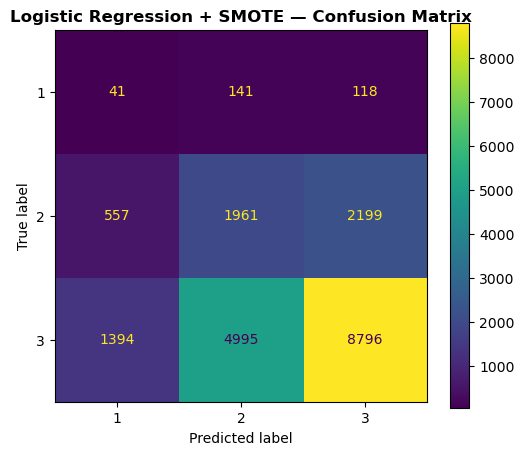

In [48]:
print("Logistic Regression + SMOTE")
print("Accuracy:", accuracy_score(y_test, lr_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, lr_pred))
print("F1 macro:", f1_score(y_test, lr_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, lr_pred, average="weighted"))
print(classification_report(y_test, lr_pred))

labels = np.sort(np.unique(y_test))
cm = confusion_matrix(y_test, lr_pred, labels=labels)

disp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(values_format="d", ax=ax)
ax.set_title("Logistic Regression + SMOTE — Confusion Matrix", fontweight="bold")
plt.show()


In [50]:
## Stratified Cross-Validation of Logistic Regression with SMOTE

from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

# Use a stratified sample (same one you used above) to keep CV fast
X_cv, y_cv = X_sm, y_sm

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    lr_smote_pipe,
    X_cv, y_cv,
    cv=cv,
    scoring="f1_macro",   # best metric for imbalanced multiclass
    n_jobs=1              # keep 1 if Windows gets stuck
)

print(f"LogReg + SMOTE CV Macro-F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print("Fold scores:", np.round(cv_scores, 4))


LogReg + SMOTE CV Macro-F1: 0.3489 ± 0.0048
Fold scores: [0.353  0.3516 0.3421]


“Cross-validation was performed on a stratified subsample due to the computational cost of SMOTE with high-dimensional one-hot encoded features.”

Due to the large dataset size, high-dimensional one-hot encoded features, and the computational cost introduced by SMOTE, 
full cross-validation on the entire dataset was computationally expensive. Therefore, cross-validation was performed on a stratified subsample
to assess model stability, while final model evaluation was conducted using a held-out test set with multiple performance metrics including
balanced accuracy and macro F1-score. This approach ensures reliable evaluation while avoiding unnecessary computational overhead.

In [54]:
## Random Forest Classifier with SMOTE for Imbalanced Severity Prediction

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

# 1) Take a STRATIFIED sample from training data (example: 20,000 rows)
X_sm, _, y_sm, _ = train_test_split(
    X_train, y_train,
    train_size=20000,          # change to 10000/30000 if needed
    random_state=42,
    stratify=y_train
)

# SMOTE (using small k for rare class)
smote = SMOTE(random_state=42, k_neighbors=2)

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)


rf_smote_pipe = ImbPipeline([
    ("prep", preprocess),
    ("smote", smote),
    ("model", rf)
])

 

In [56]:
## Random Forest + SMOTE: Model Evaluation and Confusion Matrix

rf_smote_pipe.fit(X_sm, y_sm)
rf_pred = rf_smote_pipe.predict(X_test)

Random Forest + SMOTE
Accuracy: 0.7523017523017523
Balanced Accuracy: 0.3538840997308604
F1 macro: 0.33515741667049337
F1 weighted: 0.678607643279543

Classification Report:

              precision    recall  f1-score   support

           1      0.000     0.000     0.000       300
           2      0.478     0.088     0.149      4717
           3      0.765     0.973     0.857     15185

    accuracy                          0.752     20202
   macro avg      0.414     0.354     0.335     20202
weighted avg      0.686     0.752     0.679     20202



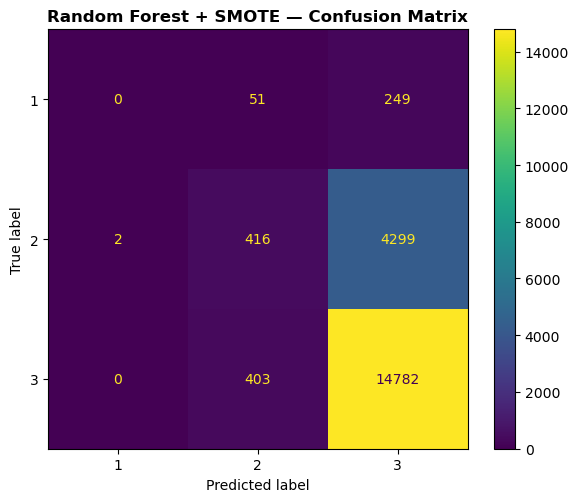

In [58]:
# Ensure class labels are consistent
classes = np.sort(np.unique(y_test))


print("Random Forest + SMOTE")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, rf_pred))
print("F1 macro:", f1_score(y_test, rf_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, rf_pred, average="weighted"))
print("\nClassification Report:\n")
print(classification_report(y_test, rf_pred, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_test, rf_pred, labels=classes)

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(values_format="d", ax=ax, colorbar=True)

ax.set_title("Random Forest + SMOTE — Confusion Matrix", fontweight="bold")
plt.tight_layout()
plt.show()


In [62]:
## Random Forest + SMOTE: Stratified Cross-Validation Results

from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np


X_cv, y_cv = X_sm, y_sm

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_cv_scores = cross_val_score(
    rf_smote_pipe,
    X_cv, y_cv,
    cv=cv,
    scoring="f1_macro",
    n_jobs=1   # keep 1 if Windows freezes; 
)

print(f"RF + SMOTE CV Macro-F1: {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")
print("Fold scores:", np.round(rf_cv_scores, 4))


RF + SMOTE CV Macro-F1: 0.3317 ± 0.0048
Fold scores: [0.3267 0.3382 0.3301]


In [64]:
## Histogram-Based Gradient Boosting: Model Definition

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

# Base HGB model (values will be overwritten during tuning)
hgb = HistGradientBoostingClassifier(
    random_state=42
)

# Pipeline (this name MUST match your tuning code)
hgb_pipe = Pipeline([
    ("prep", preprocess),
    ("model", hgb)
])


In [66]:
## Hyperparameter Tuning of Histogram Gradient Boosting Model (Stratified Cross-Validation)
import numpy as np
from sklearn.model_selection import StratifiedKFold, ParameterSampler
from sklearn.base import clone
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

# Define parameter sampler
param_dist = {
    "model__learning_rate": [0.03, 0.05, 0.08, 0.1],
    "model__max_depth": [6, 8, 10, None],
    "model__max_iter": [200, 300, 400],
    "model__min_samples_leaf": [10, 20, 30, 50],
    "model__l2_regularization": [0.0, 0.1, 0.5, 1.0],
}

sampler = list(ParameterSampler(param_dist, n_iter=20, random_state=42))
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_score = -1
best_params = None
best_model = None

for i, params in enumerate(sampler, start=1):
    fold_scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # compute fold weights on training labels only
        classes = np.unique(y_tr)
        w = compute_class_weight("balanced", classes=classes, y=y_tr)
        w_dict = dict(zip(classes, w))
        sw = np.array([w_dict[c] for c in y_tr])

        model_fold = clone(hgb_pipe)     # your Pipeline([("prep", preprocess), ("model", hgb)])
        model_fold.set_params(**params)
        model_fold.fit(X_tr, y_tr, model__sample_weight=sw)

        pred = model_fold.predict(X_val)
        fold_scores.append(f1_score(y_val, pred, average="macro"))

    mean_score = np.mean(fold_scores)

    print(f"Trial {i}/{len(sampler)} | Macro-F1={mean_score:.4f} | params={params}")

    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        best_model = clone(hgb_pipe).set_params(**params)

print("\nBEST CV Macro-F1:", best_score)
print("BEST params:", best_params)

# Fit best model on full training data with weights
classes = np.unique(y_train)

  
w = compute_class_weight("balanced", classes=classes, y=y_train)
w_dict = dict(zip(classes, w))
sample_weight_train = np.array([w_dict[c] for c in y_train])

best_model.fit(X_train, y_train, model__sample_weight=sample_weight_train)


Trial 1/20 | Macro-F1=0.3861 | params={'model__min_samples_leaf': 10, 'model__max_iter': 400, 'model__max_depth': None, 'model__learning_rate': 0.05, 'model__l2_regularization': 1.0}
Trial 2/20 | Macro-F1=0.3862 | params={'model__min_samples_leaf': 10, 'model__max_iter': 200, 'model__max_depth': None, 'model__learning_rate': 0.08, 'model__l2_regularization': 0.1}
Trial 3/20 | Macro-F1=0.3840 | params={'model__min_samples_leaf': 10, 'model__max_iter': 200, 'model__max_depth': 6, 'model__learning_rate': 0.05, 'model__l2_regularization': 1.0}
Trial 4/20 | Macro-F1=0.3853 | params={'model__min_samples_leaf': 30, 'model__max_iter': 300, 'model__max_depth': 8, 'model__learning_rate': 0.08, 'model__l2_regularization': 1.0}
Trial 5/20 | Macro-F1=0.3836 | params={'model__min_samples_leaf': 20, 'model__max_iter': 300, 'model__max_depth': None, 'model__learning_rate': 0.05, 'model__l2_regularization': 0.5}
Trial 6/20 | Macro-F1=0.3842 | params={'model__min_samples_leaf': 10, 'model__max_iter': 20

Pipeline(steps=[('prep',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'day_of_week', 'speed_limit',
                                                   'road_type',
                                                   'junction_detail',
                                                   'junction_control',
                                                   'pedestrian_crossing',
                                                   'light_conditions',
                                                   'weather_conditions',
                                                   'road_surface_...
                                                   'lon_bin', 'is_bank_holiday',
                                                   'temp_max', 'temp_min',
                                                   'precip_sum', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['date', 'time',
                                                   'date_only'])])),
                ('model',
                 HistGradientBoostingClassifier(l2_regularization=0.5,
                                                max_iter=300,
                                                min_samples_leaf=10,
                                                random_state=42))])

In [68]:
best_model.fit(X_train, y_train, model__sample_weight=sample_weight_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'day_of_week', 'speed_limit',
                                                   'road_type',
                                                   'junction_detail',
                                                   'junction_control',
                                                   'pedestrian_crossing',
                                                   'light_conditions',
                                                   'weather_conditions',
                                                   'road_surface_...
                                                   'lon_bin', 'is_bank_holiday',
                                                   'temp_max', 'temp_min',
                                                   'precip_sum', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['date', 'time',
                                                   'date_only'])])),
                ('model',
                 HistGradientBoostingClassifier(l2_regularization=0.5,
                                                max_iter=300,
                                                min_samples_leaf=10,
                                                random_state=42))])

In [70]:
##Final Model Selection and Evaluation on Hold-Out Test Set

final_pipe = best_model 

from sklearn.utils.validation import check_is_fitted
check_is_fitted(final_pipe)
print("final_pipe is fitted ✅")


final_pipe is fitted ✅


In [72]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report

hgb_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, hgb_pred))
print("Balanced Acc:", balanced_accuracy_score(y_test, hgb_pred))
print("Macro F1:", f1_score(y_test, hgb_pred, average="macro"))
print("Weighted F1:", f1_score(y_test, hgb_pred, average="weighted"))
print(classification_report(y_test, hgb_pred))


Accuracy: 0.5462825462825462
Balanced Acc: 0.5190357274454266
Macro F1: 0.3835114110869773
Weighted F1: 0.6080431739725917
              precision    recall  f1-score   support

           1       0.04      0.54      0.08       300
           2       0.33      0.44      0.38      4717
           3       0.85      0.58      0.69     15185

    accuracy                           0.55     20202
   macro avg       0.41      0.52      0.38     20202
weighted avg       0.72      0.55      0.61     20202



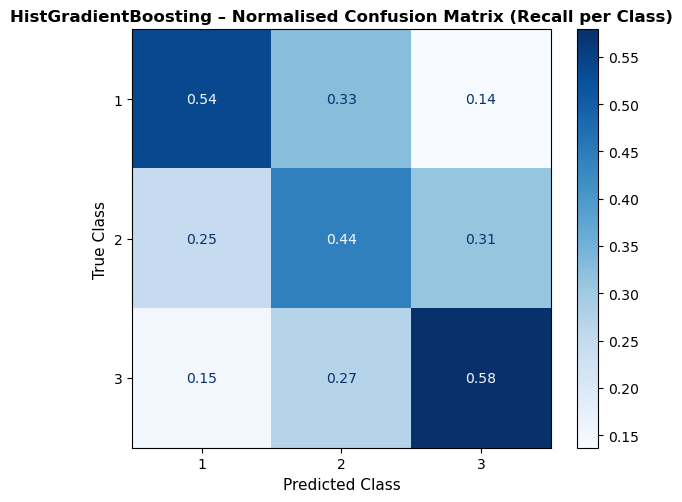

In [74]:
## HistGradientBoosting – Normalised Confusion Matrix (Recall per Class)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

labels = np.sort(np.unique(y_test))

cm = confusion_matrix(
    y_test,
    hgb_pred,
    labels=labels,
    normalize="true"
)

fig, ax = plt.subplots(figsize=(6, 5))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels
)

disp.plot(
    ax=ax,
    cmap="Blues",
    values_format=".2f",
    colorbar=True
)


ax.set_title(
    "HistGradientBoosting – Normalised Confusion Matrix (Recall per Class)",
    fontsize=12,
    fontweight="bold"
)

ax.set_xlabel("Predicted Class", fontsize=11)
ax.set_ylabel("True Class", fontsize=11)

plt.tight_layout()
plt.show()


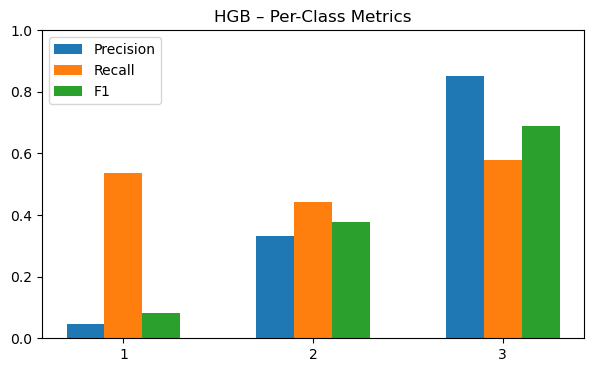

In [76]:
## Per-Class Performance Metrics for HistGradientBoosting Model

from sklearn.metrics import precision_recall_fscore_support

p, r, f1, s = precision_recall_fscore_support(y_test, hgb_pred, labels=labels, zero_division=0)

x = np.arange(len(labels))
plt.figure(figsize=(7,4))
plt.bar(x - 0.2, p, width=0.2, label="Precision")
plt.bar(x, r, width=0.2, label="Recall")
plt.bar(x + 0.2, f1, width=0.2, label="F1")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.title("HGB – Per-Class Metrics")
plt.legend()
plt.show()


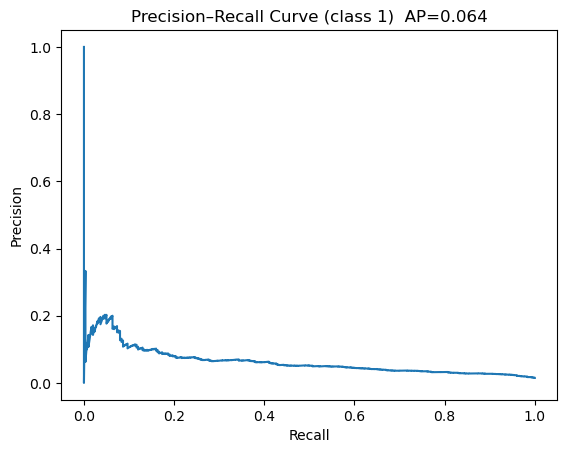

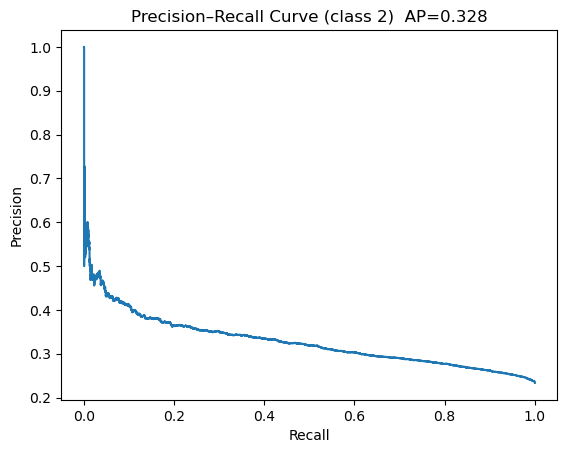

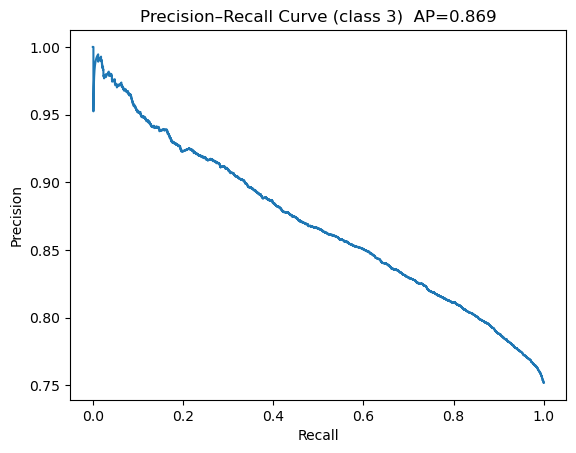

In [78]:
## Class-wise Precision–Recall Curve Analysis (Average Precision)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# needs predict_proba
proba = final_pipe.predict_proba(X_test)

labels = np.sort(np.unique(y_test))
y_bin = label_binarize(y_test, classes=labels)

for i, cls in enumerate(labels):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], proba[:, i])
    ap = average_precision_score(y_bin[:, i], proba[:, i])
    plt.figure()
    plt.plot(recall, precision)
    plt.title(f"Precision–Recall Curve (class {cls})  AP={ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()


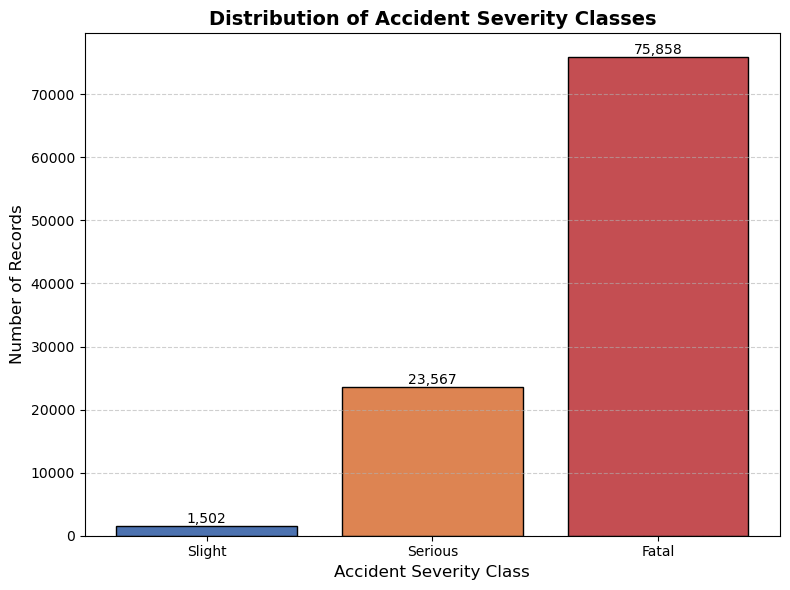

In [80]:
## Distribution of Road Accident Severity Class

import matplotlib.pyplot as plt

# Count severity classes from full dataset
severity_counts = df['collision_severity'].value_counts().sort_index()

severity_map = {
    1: "Slight",
    2: "Serious",
    3: "Fatal"
}
severity_counts.index = severity_counts.index.map(severity_map)

colors = ["#4C72B0", "#DD8452", "#C44E52"] 

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(
    severity_counts.index,
    severity_counts.values,
    color=colors,
    edgecolor="black"
)

# Labels & title
plt.xlabel("Accident Severity Class", fontsize=12)
plt.ylabel("Number of Records", fontsize=12)
plt.title(
    "Distribution of Accident Severity Classes",
    fontsize=14,
    fontweight="bold"
)

# Grid (Y-axis only)
plt.grid(axis="y", linestyle="--", alpha=0.6)


for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height):,}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()


In [82]:
## Model Performance Comparison Across Accident Severity Classes

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

lr_acc = accuracy_score(y_test, lr_pred)
lr_bal_acc = balanced_accuracy_score(y_test, lr_pred)
lr_f1_macro = f1_score(y_test, lr_pred, average="macro")

rf_acc = accuracy_score(y_test, rf_pred)
rf_bal_acc = balanced_accuracy_score(y_test, rf_pred)
rf_f1_macro = f1_score(y_test, rf_pred, average="macro")

hgb_acc = accuracy_score(y_test, hgb_pred)
hgb_bal_acc = balanced_accuracy_score(y_test, hgb_pred)
hgb_f1_macro = f1_score(y_test, hgb_pred, average="macro")


import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

results = pd.DataFrame([
    {"Model":"LogReg + SMOTE", "Accuracy": lr_acc, "BalancedAcc": lr_bal_acc, "MacroF1": lr_f1_macro},
    {"Model":"RF + SMOTE",     "Accuracy": rf_acc, "BalancedAcc": rf_bal_acc, "MacroF1": rf_f1_macro},
    {"Model":"HGB (weights)",  "Accuracy": hgb_acc,
                               "BalancedAcc": hgb_bal_acc,
                               "MacroF1": hgb_f1_macro}
])

results.sort_values("MacroF1", ascending=False)


,Model,Accuracy,BalancedAcc,MacroF1
2,HGB (weights),0.546283,0.519036,0.383511
0,LogReg + SMOTE,0.534502,0.377218,0.345568
1,RF + SMOTE,0.752302,0.353884,0.335157


In [84]:
import joblib 
joblib.dump(hgb_pipe, "final_hgb_model.pkl")
print("Saved: final_hgb_model.pkl")

final_model = joblib.load("final_hgb_model.pkl")


Saved: final_hgb_model.pkl
